# Single-cell Analysis on HCA Data using Pegasus

**Author:** [Yiming Yang](https://github.com/yihming)<br />
**Date:** 2021-05-12

In this tutorial, we use Pegasus, a Python package for single-cell analysis and also part of Cumulus, to analyze HCA dataset on cloud environment via Terra Notebook.

Starting from a human liver dataset from HCA project "[Dissecting the human liver cellular landscape by single cell RNA-seq reveals novel intrahepatic monocyte/ macrophage populations](https://dev.singlecell.gi.ucsc.edu/explore/projects)", we first downsample it with one specific donor, and then perform downstream analysis (quality control, dimension reduction, clustering, differential expression analysis, plotting, etc.).

For more information on the data, please refer to [[S. MacParland, et. al., Nature communications, 2018]](https://www.nature.com/articles/s41467-018-06318-7).

## Create Cloud Environment

To use Terra Notebook, you need to first create your own cloud environment on Terra. We've provided the prebuilt `Pegasuspy` environment which can be selected during the creation. It includes Python 3.7, Pegasus and its dependencies, as well as necessary tools to be used in this tutorial.

See [here](https://pegasus.readthedocs.io/en/latest/terra_notebook.html) for a step-by-step tutorial on setting up your cloud environment for Pegasus.

In this tutorial, we use Pegasus environment with 4 CPUs. Now import Pegasus and necessary packages for this tutorial:

In [1]:
import pegasus as pg

## Import Data

We need to fetch the `loom` format data into the cloud environment. This can be done by using Google Cloud SDK tool `gsutil` from its storage on Google Cloud:

In [2]:
#!gsutil -m cp gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom .

Now load it into memory using `read_input` function:

In [3]:
data = pg.read_input("sc-landscape-human-liver-10XV2.loom", genome='human')
data

2021-05-12 22:51:11,054 - pegasusio.readwrite - INFO - loom file 'sc-landscape-human-liver-10XV2.loom' is loaded.
2021-05-12 22:51:11,060 - pegasusio.readwrite - INFO - Function 'read_input' finished in 219.92s.


MultimodalData object with 1 UnimodalData: 'human-rna'
    It currently binds to UnimodalData object human-rna

UnimodalData object with n_obs x n_vars = 332497 x 58347
    Genome: human; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_genes', 'n

Pegasus `read_input` function provides a unified API for loading single-cell count matrix of different format: Loom, 10X HDF5, H5AD, Zarr format, CSV, TSV, etc. See [here](https://pegasus.readthedocs.io/en/stable/api/pegasus.read_input.html#pegasus.read_input) for detailed documentation of this function.

Optionally, you can manually set genome name of the count matrix in `read_input` (as is done here) in case the file itself doesn't contain this information. Otherwise, Pegasus will infer it from the file.

The count matrix is managed as a UnimodalData object defined in [PegasusIO](https://pegasusio.readthedocs.io/) module, and users can manipulate the data from top level via MultimodalData structure, which can contain multiple UnimodalData objects as members.

UnimodalData has the following structure:

<img src="https://raw.githubusercontent.com/klarman-cell-observatory/pegasus/master/notebooks/unidata.png" width=500 />

It has 6 major parts:

* Raw count matrix: data.X, a [Scipy sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) (sometimes can be a dense matrix), with rows the cell barcodes, columns the genes/features:

In [4]:
data.X

<332497x58347 sparse matrix of type '<class 'numpy.uint32'>'
	with 41577918 stored elements in Compressed Sparse Row format>

This dataset contains $332,497$ barcodes and $58,347$ genes.

* Cell barcode attributes: `data.obs`, a [Pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with barcode as the index. In this case, `input_id` stores the donor information from which the cell comes from:

In [5]:
data.obs.head()

,antisense_reads,cell_barcode_fraction_bases_above_30_mean,cell_barcode_fraction_bases_above_30_variance,duplicate_reads,emptydrops_FDR,emptydrops_IsCell,emptydrops_Limited,emptydrops_LogProb,emptydrops_PValue,emptydrops_Total,...,reads_mapped_intergenic,reads_mapped_intronic,reads_mapped_multiple,reads_mapped_too_many_loci,reads_mapped_uniquely,reads_mapped_utr,reads_per_fragment,reads_unmapped,spliced_reads,Channel
barcodekey,,,,,,,,,,,,,,,,,,,,,
0-TGCGTGGTCTGGCGTG,0,0.950797,0.014357,0,0.0,1,0,-912.613952,1.0000,2508,...,367,209,4512,0,14739,70,1.310282,871,118,0
0-AAGCCGCGTCCAGTGC,0,0.959277,0.011117,0,0.0,1,0,-441.497519,0.0041,272,...,233,117,577,0,1536,115,1.385976,160,117,0
0-GCGCCAAAGCCCGAAA,0,0.955974,0.013103,0,0.0,1,0,-355.021727,0.9985,403,...,108,42,689,0,2616,50,1.317718,183,129,0
0-TAGGCATAGCATCATC,0,0.961083,0.011502,0,0.0,1,0,-1332.048981,1.0000,5160,...,1000,423,10520,0,34699,185,1.334428,1518,235,0
0-CCGGGATAGCTAGTGG,0,0.956168,0.012790,0,0.0,1,1,-4475.000957,0.0001,1945,...,1887,9129,6139,0,22871,2826,1.270158,1061,4389,0


In [6]:
data.obs['input_id'].value_counts()

02f207ae-217b-42ce-9733-c03e61541fcc    87538
d1782f60-75d3-41a2-a6d5-8218daab2e31    73823
2b965070-e2c5-4c26-92c9-c94483f1a00c    66422
42998245-4c46-488e-ad04-14550074d6d4    64932
3f9058b9-4243-4ef1-a345-857a5b9ff78e    39782
Name: input_id, dtype: int64

In addition, some cell barcode attributes are important metrics, including `emptydrops_IsCell` (measures if a cell is an empty droplet, as indicated by a 0), `pct_mitochondrial_molecules` (the percent of cell's mitochondrial molecules), and `n_genes` (the number of genes expressed in the cell).

* Gene attributes: data.var, also a Pandas data frame, with gene name as the index. Besides, `featureid` stores each gene's Ensembl ID:

In [7]:
data.var.head()

,antisense_reads,duplicate_reads,featureid,fragments_per_molecule,fragments_with_single_read_evidence,genomic_read_quality_mean,genomic_read_quality_variance,genomic_reads_fraction_bases_quality_above_30_mean,genomic_reads_fraction_bases_quality_above_30_variance,molecule_barcode_fraction_bases_above_30_mean,...,number_cells_expressing,perfect_molecule_barcodes,reads_mapped_exonic,reads_mapped_intronic,reads_mapped_multiple,reads_mapped_uniquely,reads_mapped_utr,reads_per_fragment,reads_per_molecule,spliced_reads
featurekey,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0,0.0,ENSG00000223972.5,1.000000,1.0,24.602041,NaN,0.306122,NaN,1.000000,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.0
WASH7P,0.0,0.0,ENSG00000227232.5,1.805882,506.0,33.015957,22.889387,0.779228,0.057938,0.971467,...,321.0,721.0,743.0,0.0,743.0,0.0,0.0,1.210098,2.185294,23.0
MIR6859-1,0.0,0.0,ENSG00000278267.1,1.000000,1.0,24.816326,NaN,0.367347,NaN,0.800000,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.0
MIR1302-2HG,0.0,0.0,ENSG00000243485.5,3.142857,19.0,34.615662,NaN,0.851380,NaN,0.974074,...,7.0,26.0,27.0,0.0,27.0,0.0,0.0,1.227273,3.857143,11.0
MIR1302-2,NaN,NaN,ENSG00000284332.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Unstructured information: `data.uns`, a Python [hashed dictionary](https://docs.python.org/3/library/collections.html#collections.OrderedDict). It usually stores information not restricted to barcodes or features, but about the whole dataset, such as its genome reference and modality type:

In [8]:
data.uns['genome']

'human'

In [9]:
data.uns['modality']

'rna'

* Finally, embedding attributes on cell barcodes: `data.obsm`; as well as on genes, `data.varm`. We'll see it in later sections.

## Single-Cell Analysis

In the following sections, we'll choose a subset of the data with respect to one specific donor (with input_id `02f207ae-217b-42ce-9733-c03e61541fcc`), and perform single-cell analysis on it:

In [10]:
data._inplace_subset_obs(data.obs['input_id']=='02f207ae-217b-42ce-9733-c03e61541fcc')
data

MultimodalData object with 1 UnimodalData: 'human-rna'
    It currently binds to UnimodalData object human-rna

UnimodalData object with n_obs x n_vars = 87538 x 58347
    Genome: human; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_genes', 'n_

This donor has $87,538$ cells.

### Quality Control

The first step is to perform the quality control analysis, and remove cells and genes of low quality.

We can generate QC metrics using `qc_metrics` function with the following settings:

In [11]:
pg.qc_metrics(data, min_genes=1, max_genes=2500, mito_prefix='MT-', percent_mito=10)

The metrics considered are:
* **Number of genes:** Keep cells with $1$ ≤ # Genes < $2500$;
* **Number of UMIs:** Don't filter cells due to UMI bounds (*Default*);
* **Percent of Mitochondrial genes:** Look for mitochondrial (MT) genes of name starting with `MT-`. Keep cells with percent of MT genes $<10\%$.

For details on customizing your own thresholds, see [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.qc_metrics.html).

Numeric summaries on filtration on cell barcodes and genes can be achieved by `get_filter_stats` method:

In [12]:
df_qc = pg.get_filter_stats(data)
df_qc

,kept,median_n_genes,median_n_umis,median_percent_mito,filt,total,median_n_genes_before,median_n_umis_before,median_percent_mito_before
Channel,,,,,,,,,
0,342,835.5,2745.5,7.879064,87196,87538,97,222,62.755102


The results is a Pandas data frame with each column for one sample. Here, we only have one donor (`Channel` attribute is `0`), so summaries on all the other samples are 0.

You can also check the QC stats via plots. Below is on number of genes:

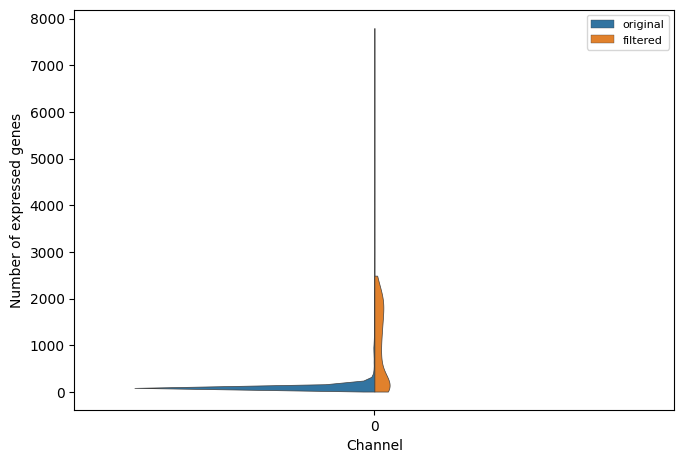

In [13]:
pg.qcviolin(data, plot_type='gene', dpi=100)

Then on number of UMIs:

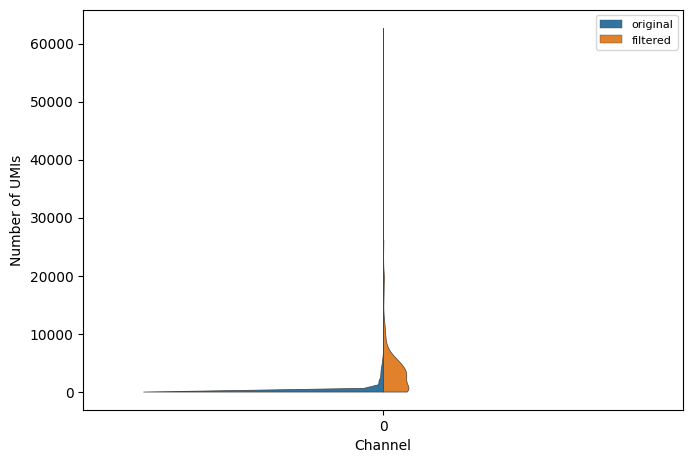

In [14]:
pg.qcviolin(data, plot_type='count', dpi=100)

On number of percentage of mitochondrial genes:

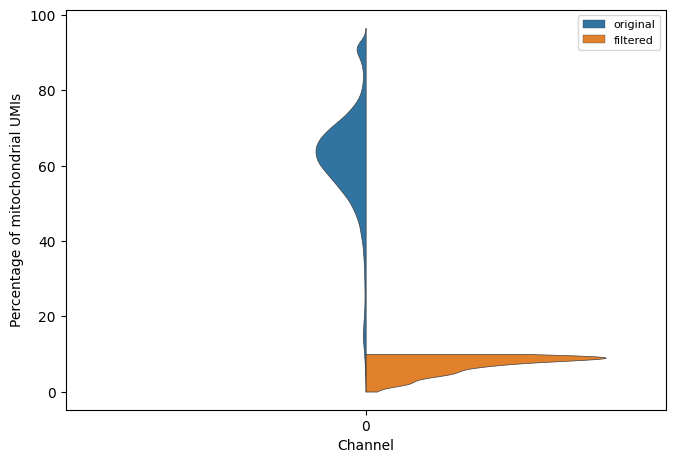

In [15]:
pg.qcviolin(data, plot_type='mito', dpi=100)

Besides these 3 commonly used QC metrics, you can use other ones stored in `obs` field for filtering. For example, `emptydrops_IsCell`:

In [16]:
data.obs['emptydrops_IsCell'].value_counts()

0    46766
1    40772
Name: emptydrops_IsCell, dtype: int64

You can further filter the data using this metric, which will have $40,772$ cells left. To do that, it is similar to creating a subset of the original count matrix above. You can uncomment the following section to achieve that:

In [17]:
#data._inplace_subset_obs(data.obs['emptydrops_IsCell']==1)

Now filter cells based on QC metrics set in `qc_metrics`:

In [18]:
pg.filter_data(data)

2021-05-12 22:51:12,834 - pegasusio.qc_utils - INFO - After filtration, 342 out of 87538 cell barcodes are kept in UnimodalData object human-rna.
2021-05-12 22:51:12,834 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.12s.


You can see that $342$ cells are kept.

Moreover, for genes, only those with no cell expression are removed. After that, we identify **robust** genes for downstream analysis:

In [19]:
pg.identify_robust_genes(data)

2021-05-12 22:51:12,933 - pegasus.tools.preprocessing - INFO - After filtration, 17480/58347 genes are kept. Among 17480 genes, 17480 genes are robust.
2021-05-12 22:51:12,934 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.09s.


`identify_robust_genes` function first remove those genes with no cell expressing them, which has $17,480$ genes left. Then it uses the following metric to identify robust genes:
* Gene is expressed in at least $0.05\%$ of cells, i.e. among every 6000 cells, there are at least 3 cells expressing this gene.

As this dataset is pretty small after filtering cells, the default $0.05\%$ is actually $0$, meaning that the remaining genes are all robust.

Please see [its documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.identify_robust_genes.html) for details.

### Log-normalization

After filtration, we need to first normalize the distribution of counts w.r.t. each cell to have the same sum (default is $10^5$, see [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.log_norm.html)), and then transform into logarithmic space by $log(x+1)$ to avoid number explosion:

In [20]:
pg.log_norm(data)

2021-05-12 22:51:12,949 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.01s.


### Select Highly Variable Features

**Highly Variable Features (HVF)** are more likely to convey information discriminating different cell types and states. Thus, rather than considering all genes, people usually focus on selected HVFs for downstream analyses.

HVFs are selected from robust genes identified above. In addition, you need to set `consider_batch` flag to consider or not consider batch effect during the selection. Since there is only one sample here, you should set it to `False`:

In [21]:
pg.highly_variable_features(data, consider_batch=False)

2021-05-12 22:51:12,957 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.00s.
2021-05-12 22:51:12,998 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2021-05-12 22:51:12,998 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.04s.


By default, we select $2000$ HVFs using the pegasus selection method. Alternative, you can also choose the traditional method that both Seurat and SCANPY use, by setting `flavor='Seurat'`. See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.highly_variable_features.html) for details.

We can view HVFs by ranking them from top:

In [22]:
data.var.loc[data.var['highly_variable_features']].sort_values(by='hvf_rank')

,antisense_reads,duplicate_reads,featureid,fragments_per_molecule,fragments_with_single_read_evidence,genomic_read_quality_mean,genomic_read_quality_variance,genomic_reads_fraction_bases_quality_above_30_mean,genomic_reads_fraction_bases_quality_above_30_variance,molecule_barcode_fraction_bases_above_30_mean,...,reads_per_molecule,spliced_reads,n_cells,percent_cells,robust,highly_variable_features,mean,var,hvf_loess,hvf_rank
featurekey,,,,,,,,,,,,,,,,,,,,,
HBA1,0.0,0.0,ENSG00000206172.8,5.074055,1124194.0,32.279510,25.866257,0.739059,0.068981,0.962203,...,5.802186,577815.0,159,46.491228,True,True,3.144765,15.499605,6.734579,1
HBB,0.0,0.0,ENSG00000244734.3,7.932229,2410712.0,34.472542,14.437325,0.845814,0.039815,0.967429,...,9.454004,860877.0,239,69.883041,True,True,4.692738,16.543134,7.693554,2
HBA2,0.0,0.0,ENSG00000188536.12,5.013353,1083875.0,32.464790,25.148745,0.748488,0.066890,0.962076,...,5.737326,577578.0,163,47.660819,True,True,3.072382,14.293973,6.623949,3
HBD,0.0,0.0,ENSG00000223609.7,7.114737,61705.0,34.150475,16.710175,0.828592,0.046093,0.969114,...,8.422227,23998.0,95,27.777778,True,True,1.635301,7.944987,4.249269,30
IGHG1,0.0,0.0,ENSG00000211896.7,4.755211,319451.0,33.821728,19.935104,0.815256,0.052244,0.957616,...,5.469046,4070.0,68,19.883041,True,True,0.980620,5.229134,2.819322,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TXNDC17,0.0,0.0,ENSG00000129235.10,6.168974,10669.0,34.821915,13.397641,0.862210,0.036658,0.973419,...,7.621002,12549.0,51,14.912281,True,True,0.512316,1.673697,1.608816,3983
NUDCD3,0.0,0.0,ENSG00000015676.17,4.312321,1239.0,33.872566,17.282541,0.817391,0.045858,0.964481,...,5.332378,53.0,10,2.923977,True,True,0.100637,0.353429,0.326560,3984
TRIM33,0.0,0.0,ENSG00000197323.11,4.983707,2042.0,34.873642,10.387067,0.866197,0.028603,0.973820,...,6.083503,288.0,20,5.847953,True,True,0.198414,0.676026,0.635575,3987


We can also view HVGs in a scatterplot:

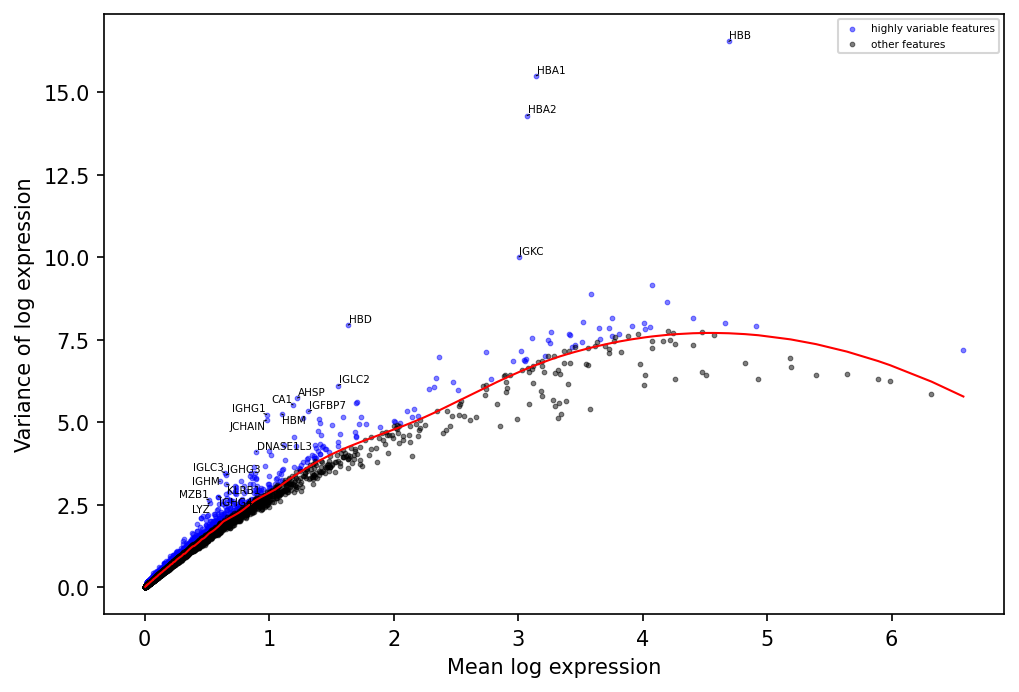

In [23]:
pg.hvfplot(data, dpi=150)

In this plot, each point stands for one gene. Blue points are selected to be HVFs, which account for the majority of variation of the dataset.

### Principal Component Analysis

To reduce the dimension of data, Principal Component Analysis (PCA) is widely used. Briefly speaking, PCA transforms the data from original dimensions into a new set of Principal Components (PC) of a much smaller size. In the transformed data, dimension is reduced, while PCs still cover a majority of the variation of data. Moreover, the new dimensions (i.e. PCs) are independent with each other.

Pegasus uses the following method to perform PCA:

In [24]:
pg.pca(data)

2021-05-12 22:51:14,441 - pegasus.tools.preprocessing - INFO - Function 'pca' finished in 0.13s.


By default, pca uses:
* Before PCA, scale the data to standard Normal distribution N(0,1), and truncate them with max value 10;
* Number of PCs to compute: 50;
* Apply PCA only to highly variable features.

See [its documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.pca.html) for customization.

You can then create a scatter plot on this PCA embedding, specifying one gene, such as CST3:

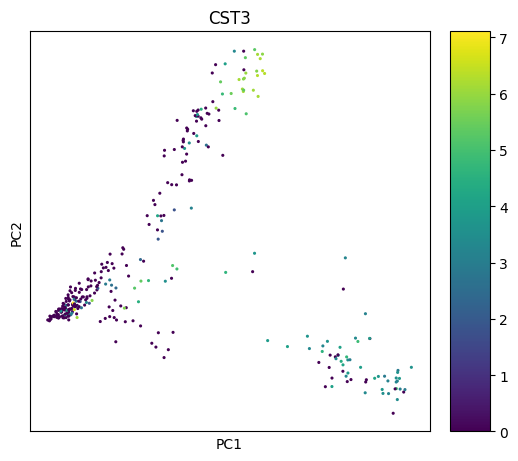

In [25]:
pg.scatter(data, basis='pca', attrs=['CST3'], dpi=100, cmaps='viridis')

### Clustering

All the downstream analysis, including clustering and visualization, needs to construct a k-Nearest-Neighbor (kNN) graph on cells. We can build such a graph using `neighbors` function:

In [26]:
pg.neighbors(data, K=10)

2021-05-12 22:51:14,707 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.11s.
2021-05-12 22:51:14,717 - pegasus.tools.nearest_neighbors - INFO - Function 'calculate_affinity_matrix' finished in 0.01s.


It uses the following setting:
* For each cell, calculate its 10 nearest neighbors;
* Use PCA matrix for calculation (*Default*);
* Use Euclidean (L2) distance as the metric;
* Use [hnswlib](https://github.com/nmslib/hnswlib) search algorithm to calculate the approximated nearest neighbors in a really short time.

See [its documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.neighbors.html) for customization.

Now we are ready to cluster the data using community-detection algorithms. Pegasus provides 4 such methods (see [details](https://pegasus.readthedocs.io/en/stable/api/index.html#cluster-algorithms)):
* `louvain`: Louvain algorithm, by [[Blondel et al., 2008]](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta).
* `leiden`: Leiden algorithm, by [[Traag et al., 2019]](https://www.nature.com/articles/s41598-019-41695-z)
* `spectral_louvain`: Spectral Louvain algorithm, which requires Diffusion Map. ([[Li et al., 2020]](https://www.nature.com/articles/s41592-020-0905-x))
* `spectral_leiden`: Spectral Leiden algorithm, which requires Diffusion Map. ([[Li et al., 2020]](https://www.nature.com/articles/s41592-020-0905-x))

In this tutorial, we use Leiden algorithm:

In [27]:
pg.leiden(data, resolution=1.0)

2021-05-12 22:51:14,731 - pegasus.tools.graph_operations - INFO - Function 'construct_graph' finished in 0.00s.
2021-05-12 22:51:14,738 - pegasus.tools.clustering - INFO - Leiden clustering is done. Get 9 clusters.
2021-05-12 22:51:14,739 - pegasus.tools.clustering - INFO - Function 'leiden' finished in 0.02s.


The `resolution` parameter indirectly determines the number of clusters. See [here](https://pegasus.readthedocs.io/en/stable/api/pegasus.leiden.html#pegasus.leiden) for details.

As a result, we achieve 9 clusters, with cluster labels stored as `leiden_labels` attribute in `obs` field:

In [28]:
data.obs['leiden_labels'].value_counts()

1    69
2    60
3    60
4    40
5    33
6    28
7    25
8    17
9    10
Name: leiden_labels, dtype: int64

### Visualization

Pegasus provides these visualization methods: tSNE, UMAP, and FLE (Force-directed Layout). In this tutorial, we only show UMAP. You can see [here](https://pegasus.readthedocs.io/en/stable/api/index.html#visualization-algorithms) for a complete list of all available visualization methods.

The UMAP embedding of cells are calculated as below:

In [29]:
pg.umap(data)

2021-05-12 22:51:14,858 - pegasus.tools.nearest_neighbors - INFO - Function 'get_neighbors' finished in 0.11s.
UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, random_state=0, verbose=True)
Construct fuzzy simplicial set
Wed May 12 22:51:15 2021 Finding Nearest Neighbors
Wed May 12 22:51:16 2021 Finished Nearest Neighbor Search
Wed May 12 22:51:18 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed May 12 22:51:19 2021 Finished embedding
2021-05-12 22:51:19,585 - pegasus.tools.visualization - INFO - Using umap kNN graph because number of cells 342 is smaller than 4096 or knn_indices is not provided.
2021-05-12 22:51:19,585 - pegasus.tools.visualization - INFO - Function 'umap' finished in 4.83s.


Now we can see scatter plots using UMAP embedding (*Default*) on cluster labels, as well as genes (e.g. CST3, NKG7, PPBP), of cells:

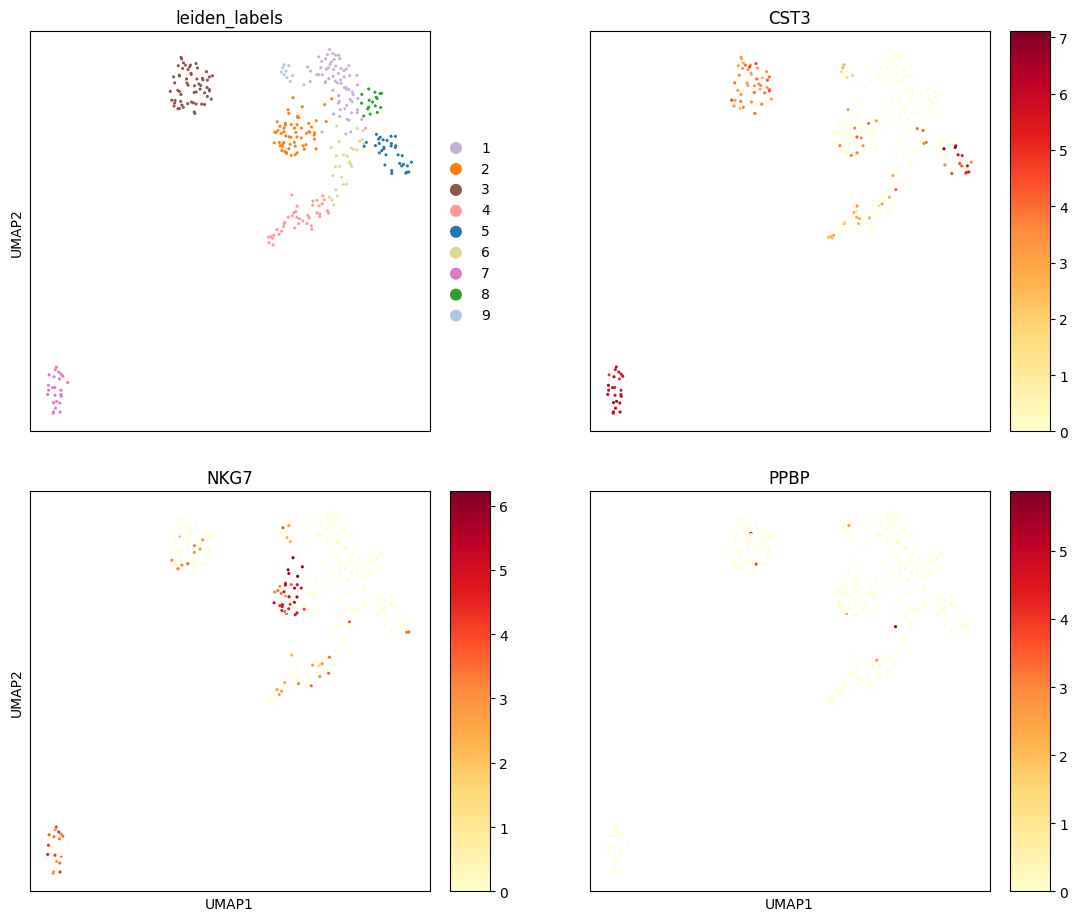

In [30]:
pg.scatter(data, attrs=['leiden_labels', 'CST3', 'NKG7', 'PPBP'], dpi=100)

### Differential Expression Analysis

With the clusters ready, we can now perform Differential Expression (DE) Analysis. DE analysis is to discover cluster-specific marker genes. For each cluster, it compares cells within the cluster with all the others, then finds genes significantly highly expressed (up-regulated) and lowly expressed (down-regulated) for the cluster.

Now use `de_analysis` function to run DE analysis. We use Leiden result here:

In [31]:
pg.de_analysis(data, cluster='leiden_labels')

2021-05-12 22:51:20,009 - pegasus.tools.diff_expr - INFO - CSR matrix is converted to CSC matrix. Time spent = 0.0044s.
2021-05-12 22:51:35,485 - pegasus.tools.diff_expr - INFO - MWU test and AUROC calculation are finished. Time spent = 15.4757s.
2021-05-12 22:51:35,513 - pegasus.tools.diff_expr - INFO - Sufficient statistics are collected. Time spent = 0.0285s.
2021-05-12 22:51:35,553 - pegasus.tools.diff_expr - INFO - Differential expression analysis is finished.
2021-05-12 22:51:35,553 - pegasus.tools.diff_expr - INFO - Function 'de_analysis' finished in 15.55s.


By default, DE analysis runs Mann-Whitney U (MWU) test only, which is a nonparametric significance test and usually performs better on single-cell genomics data.

Alternatively, you can also run the follow tests by setting their corresponding parameters to be `True` in `de_analysis` function:
* `fisher`: Fisher’s exact test.
* `t`: Welch’s T test.

DE analysis result is stored with key `de_res` (by default) in `varm` field of data. See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.de_analysis.html) for more details.

To load the result in a human-readable format, use `markers` method:

In [32]:
marker_dict = pg.markers(data)

By default, `markers` function:
* Sorts genes by Area under ROC curve (AUROC) in descending order;
* Selects significant genes in False Discover Rate (FDR) control of $\alpha = 0.05$.

See [documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.markers.html) for customizing these settings.

Let's see the up-regulated genes for Cluster 2, and rank them in descending order with respect to log fold change:

In [33]:
marker_dict['2']['up'].sort_values(by='log2FC', ascending=False)

,log2Mean,log2Mean_other,log2FC,percentage,percentage_other,percentage_fold_change,auroc,mwu_U,mwu_pval,mwu_qval
feature,,,,,,,,,,
RPL10P9,9.244493,4.299086,4.945407,98.333336,53.900711,1.824342e+00,0.877128,14841.0,3.587048e-21,2.090053e-18
RPS29,9.098837,4.217833,4.881004,98.333336,55.319149,1.777564e+00,0.924291,15639.0,3.070602e-26,3.833866e-23
IL32,5.122840,0.459192,4.663648,71.666664,8.510638,8.420833e+00,0.836939,14161.0,2.727337e-32,2.383692e-28
RPL10,9.683189,5.069748,4.613441,100.000000,59.929077,1.668639e+00,0.851891,14414.0,2.793777e-18,1.109892e-15
CXCR4,5.242779,0.631967,4.610812,78.333336,13.120567,5.970271e+00,0.864391,14625.5,8.443772e-32,4.919905e-28
...,...,...,...,...,...,...,...,...,...,...
XRCC3,0.142940,0.000000,0.142940,3.333333,0.000000,1.000000e+30,0.516667,8742.0,2.176772e-03,3.283000e-02
AC010168.2,0.142703,0.000000,0.142703,3.333333,0.000000,1.000000e+30,0.516667,8742.0,2.176772e-03,3.283000e-02
ZNF737,0.141168,0.000000,0.141168,3.333333,0.000000,1.000000e+30,0.516667,8742.0,2.176772e-03,3.283000e-02


We can also use Volcano plot to see the DE result. Below is such a plot w.r.t. Cluster 2 with MWU test results (by default):

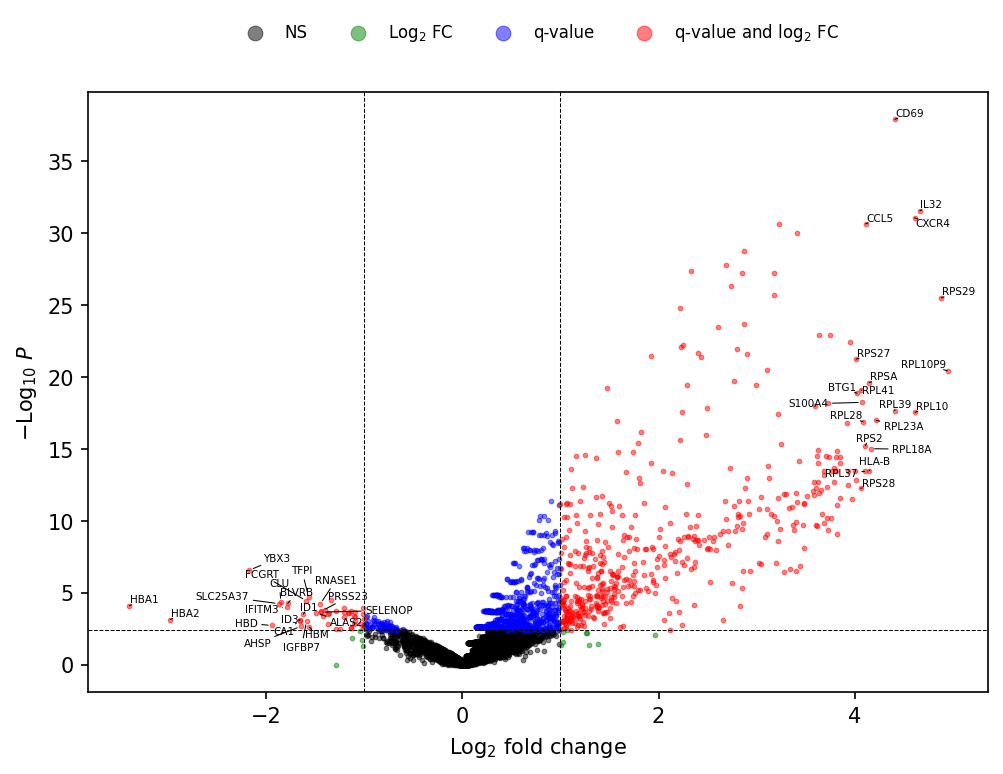

In [34]:
pg.volcano(data, cluster_id = '2', dpi=150)

The plot above uses the default thresholds: log fold change at $1$ (i.e. fold change at $2$), and p-value under FDR control at $0.05$. Each point stands for a gene. Red ones are significant marker genes: those at right-hand side are up-regulated genes for Cluster 2, while those at left-hand side are down-regulated genes. Besides, only show top 20 genes at both sides regarding log fold change.

See [its documentation](https://pegasus.readthedocs.io/en/stable/api/pegasus.volcano.html) for customization.

To store the whole DE analysis result to file, you can use `write_results_to_excel` function:

In [35]:
pg.write_results_to_excel(marker_dict, "human_liver_channel_0.de.xlsx")

2021-05-12 22:51:54,508 - pegasus.tools.diff_expr - INFO - Excel spreadsheet is written.
2021-05-12 22:51:54,520 - pegasus.tools.diff_expr - INFO - Function 'write_results_to_excel' finished in 1.83s.


## Raw Count vs Log-norm Count

Now let's check the count matrix of one donor:

In [36]:
data

MultimodalData object with 1 UnimodalData: 'human-rna'
    It currently binds to UnimodalData object human-rna

UnimodalData object with n_obs x n_vars = 342 x 17480
    Genome: human; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_ge

You can see that besides `X`, there is another matrix `raw.X` generated for this analysis. As the key name indicates, `raw.X` stores the raw count matrix, which is the one achieved immediately after subsetting; while `X` stores the log-normalized counts.

`data` currently binds to matrix `X`. To use the raw count instead, type:

In [37]:
data.select_matrix('raw.X')
data

MultimodalData object with 1 UnimodalData: 'human-rna'
    It currently binds to UnimodalData object human-rna

UnimodalData object with n_obs x n_vars = 342 x 17480
    Genome: human; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'raw.X' as X

    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', '

Now `data` binds to raw counts. You can switch back to log-normalized counts by:

In [38]:
data.select_matrix('X')

## Save Results to Google Bucket

When done with the analysis, you can use `write_output` function to save the resulting data to file:

In [39]:
pg.write_output(data, "human_liver_channel_0.zarr.zip")

2021-05-12 22:51:54,540 - pegasusio.zarr_utils - WARNING - Detected and removed pre-existing file human_liver_channel_0.zarr.zip.
2021-05-12 22:51:54,749 - pegasusio.readwrite - INFO - zarr.zip file 'human_liver_channel_0.zarr.zip' is written.
2021-05-12 22:51:54,750 - pegasusio.readwrite - INFO - Function 'write_output' finished in 0.21s.


Similarly as `read_input`, `write_output` function also provides a unified API for writing count matrix to file of different formats (Loom, 10X HDF5, H5AD, Zarr, CSV, TSV, etc.) by simplying specifying the file extension. See [here](https://pegasus.readthedocs.io/en/stable/api/pegasus.write_output.html) for details.

Finally, we need to send all the results from the Cloud environment to the Google bucket of the current workspace for storage. To do that, we need the bucket ID of the workspace, which can be achieved by:

In [40]:
import os

bucket = os.environ['WORKSPACE_BUCKET']

Now copy files to the target folder of the bucket using `gsutil`:

In [41]:
#!gsutil -m cp human_liver_channel_0.zarr.zip human_liver_channel_0.de.xlsx $bucket/hca_demo/

where `hca_demo` is the target folder name on the Google bucket, which is free to change.